In [12]:
import numpy as np
import pandas as pd
from sentence_transformers import util, SentenceTransformer

# Load data and embeddings
df = pd.read_csv("results/02_ai_scores.csv")
emb = np.load("results/01_embeddings.npy")

# Load SBERT model
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")


In [24]:
print(df.shape)
print(emb.shape)

(886718, 10)
(1200456, 768)


clean the dataframe

In [13]:
def clean_df(df):
    """If dataframe has publisher/title columns, clean it."""
    if 'publisher' in df.columns:
        df = df[df['publisher'] != 'sn.dk'].copy()
    if 'publisher' in df.columns and 'title' in df.columns:
        df = df.drop_duplicates(subset=['publisher', 'title'])
    return df

In [15]:
df

,plain_text,published_date,title,tags,categories,author,sitename,publisher,ai_score,is_ai
0,1.200 danske vinavlere har haft en sensationel...,2016-10-22,1.200 danske vinavlere har haft en sensationel...,NaN,NaN,Guldborgsundavis Dk,www.guldborgsundavis.dk,guldborgsundavis.dk,0.307683,False
1,"Ung i krise Frihed, styrke og uendelig appeti...",2016-10-21,Sara blev psykisk syg som ung: Nu havde jeg ik...,"Skizofreni, psykisk sygdom, psykiske lidelser",Liv & Sjæl,Ung i krise Af Thilde Thordahl Andersen,Kristeligt Dagblad,kristeligt-dagblad.dk,0.376047,True
2,Hvis livslængden øges i samme tempo i yderlige...,2016-10-20,Det meget lange liv er både fascinerende og sk...,"alder, aldring, Tid, udvikling, sundhed",Liv & Sjæl,Boguddrag Kaare Christensen; Professor Og Aldr...,Kristeligt Dagblad,kristeligt-dagblad.dk,0.383773,True
3,Læs også relevante temaer Den republikanske ...,2016-10-20,Trump chokerer i tv-debat,"Trump, Clinton, præsidentvalg",Udland,Af Sidsel Nyholm; Korrespondent; USA,Kristeligt Dagblad,kristeligt-dagblad.dk,0.292969,False
4,Læs også Hvorfor skifter bladene farve? Hvorn...,2016-10-20,Test din viden om efteråret,"efterår, Quiz, blade, trækfugl",Quiz,Efterårsquiz Af Rasmus Fahrendorff,Kristeligt Dagblad,kristeligt-dagblad.dk,0.326066,True
...,...,...,...,...,...,...,...,...,...,...
1200451,Hvalpedåb på søbadet Fem nye vinterbader-hval...,2024-01-31,Hvalpedåb på søbadet - Dragør Nyt,NaN,NaN,Admin,Dragør Nyt,dragoer-nyt.dk,0.341686,True
1200452,Nu skal der mere liv i det gamle værft Kommun...,2024-01-31,Nu skal der mere liv i det gamle værft - Dragø...,NaN,NaN,Admin,Dragør Nyt,dragoer-nyt.dk,0.464745,True
1200453,Vinder Rolex 24-løbet Christian Rasmussen sta...,2024-01-31,Vinder Rolex 24-løbet - Dragør Nyt,NaN,NaN,Admin,Dragør Nyt,dragoer-nyt.dk,0.255012,False
1200454,"Den er god nok. Det var en hanulv, der torsda...",2024-01-31,Ulv eller hund?: Nu er svaret kommet,Samfund,Nyheder,Per Børding,www.bt.dk,bt.dk,0.364327,True


In [17]:
# Clean all dfs that contain news-level rows
df = clean_df(df)
# Filter the primary yearly dataframe
df = df[df['published_date'] >= '2016'].copy()


In [26]:
# keep emb base on df index
emb = emb[df.index]

This paper identifies barriers using an inductive thematic analysis on 196 peer-reviewed studies, following PRISMA screening, with two independent coders extracting and grouping all challenge-related statements into recurring themes such as resistance to change, skills gaps, and data-quality/privacy issues.<Adoption and integration of AI in organizations-a systematic review of challenges and drivers towards future directions of research>

In [19]:
barrier_queries = {
    "skills_gap":      "lack of AI skills, shortage of technical skills, insufficient expertise",
    "resistance":      "employee resistance, fear of automation, opposition to AI adoption",
    "privacy":         "data privacy, GDPR concerns, personal data protection issues",
    "data_quality":    "poor data quality, missing data, inconsistent datasets",
    "ethics_bias":     "algorithmic bias, fairness concerns, discrimination",
    "transparency":    "lack of model transparency, explainability issues, black-box AI"
}


In [27]:
# Encode barrier queries
barrier_texts = list(barrier_queries.values())
barrier_emb = model.encode(barrier_texts, normalize_embeddings=True)

# Compute similarity
barrier_scores = util.cos_sim(emb, barrier_emb).cpu().numpy()

# Assign label with maximum similarity
df["barrier_type"] = [
    list(barrier_queries.keys())[i] for i in barrier_scores.argmax(axis=1)
]

df.to_csv("results/15_barrier_classification.csv", index=False)


search only from AI-related rows

In [28]:
ai_barriers = df[df["is_ai"]]["barrier_type"].value_counts()
ai_barriers.to_csv("results/16_barrier_distribution.csv")


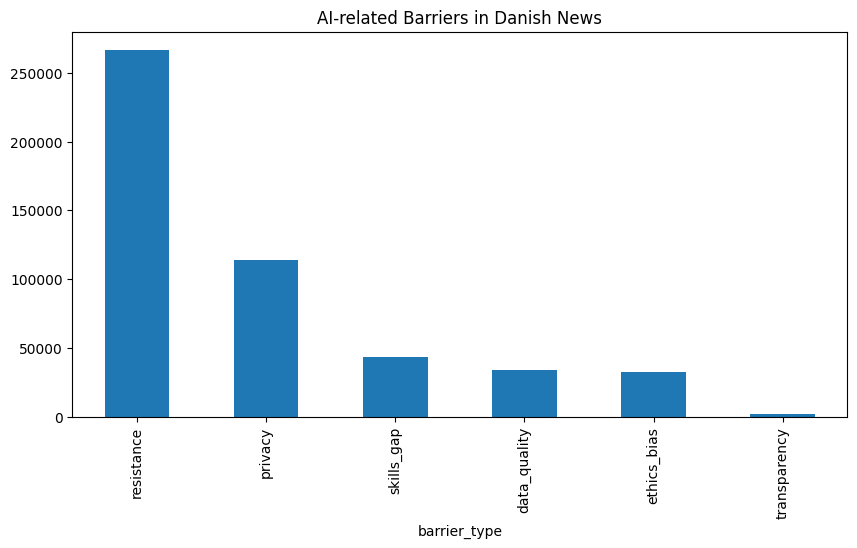

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
ai_barriers.plot(kind="bar")
plt.title("AI-related Barriers in Danish News")
plt.show()

plt.savefig("figures/plot.png", bbox_inches="tight")
plt.close()


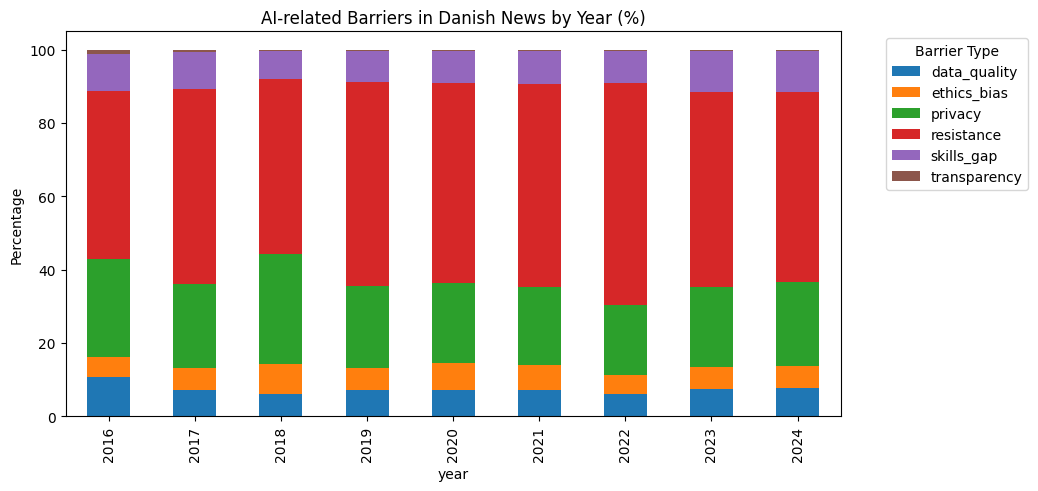

In [31]:
# AI-related Barriers in Danish News by Year in pct
df["year"] = pd.to_datetime(df["published_date"]).dt.year
barrier_year = df[df["is_ai"]].groupby(["year", "barrier_type"]).size().unstack(fill_value=0)
barrier_year_pct = barrier_year.div(barrier_year.sum(axis=1), axis=0) * 100
barrier_year_pct.plot(kind="bar", stacked=True, figsize=(10,5))
plt.title("AI-related Barriers in Danish News by Year (%)")
plt.ylabel("Percentage")
plt.legend(title="Barrier Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
